In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0005.hk')
# data.drop("Adj Close",axis=1,inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,111.0,111.5,107.50,108.0,55.387085,3908164
2000-01-04,106.0,106.5,105.00,106.0,54.361393,6895378
2000-01-05,101.0,102.0,99.50,100.5,51.540749,14657098
2000-01-06,101.0,102.0,96.25,97.0,49.745785,10632084
2000-01-07,98.5,101.0,97.50,100.5,51.540749,8368286


In [3]:
data.shift(1).head(90)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,111.00,111.50,107.50,108.00,55.387085,3908164.0
2000-01-05,106.00,106.50,105.00,106.00,54.361393,6895378.0
2000-01-06,101.00,102.00,99.50,100.50,51.540749,14657098.0
2000-01-07,101.00,102.00,96.25,97.00,49.745785,10632084.0
...,...,...,...,...,...,...
2000-05-03,88.00,88.00,86.00,86.50,45.191124,4266439.0
2000-05-04,86.50,87.00,86.00,86.25,45.060516,32018800.0
2000-05-05,85.50,86.00,85.25,86.00,44.929886,3582441.0


In [4]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].shift(1).pct_change()
data['3day MA'] = data['Close'].shift(1).rolling(window = 3).mean()
data['10day MA'] = data['Close'].shift(1).rolling(window = 10).mean()
data['30day MA'] = data['Close'].shift(1).rolling(window = 30).mean()
data['Std_dev']= data['Close'].shift(1).rolling(5).std()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 9)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'H-L', 'O-C',
       '% Change', '3day MA', '10day MA', '30day MA', 'Std_dev'],
      dtype='object')

In [5]:
data_options = pd.read_csv("Put_Call_Ratio.csv",skiprows=1)
data_options.columns

Index(['Date (D/M/Y)', ' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [6]:
data_options['Date (D/M/Y)']=pd.to_datetime(data_options['Date (D/M/Y)'], format="%d/%m/%Y")
data_options.set_index('Date (D/M/Y)',inplace=True)
data_options.sort_index(ascending=True,inplace=True)
data_options.columns

Index([' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [7]:
# data=pd.merge(data,data_options[" Put/Call Ratio"], left_index=True,right_index=True)
data=data
# data.drop(["Volume","Adj Close"], axis=1,inplace=True)

In [8]:
data.dropna(inplace=True)
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
H-L          0
O-C          0
% Change     0
3day MA      0
10day MA     0
30day MA     0
Std_dev      0
dtype: int64

In [9]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev
Date,,,,,,,,,,,,,
2000-02-15,87.0,88.00,86.25,87.75,45.001995,18810191,1.75,0.75,-0.030471,89.166667,90.55,94.500000,1.267379
2000-02-16,89.0,93.50,88.75,92.50,47.438000,17841441,4.75,3.50,0.002857,88.500000,90.10,93.825000,1.483240
2000-02-17,92.0,94.25,92.00,93.00,47.694439,10789190,2.25,1.00,0.054131,89.250000,90.15,93.375000,2.041752
2000-02-18,93.0,93.50,90.50,91.25,46.796944,10116832,3.00,-1.75,0.005405,91.083333,90.30,93.125000,2.570263
2000-02-21,90.0,91.00,88.50,89.50,45.899479,8839331,2.50,-0.50,-0.018817,92.250000,90.30,92.933333,2.613666


In [10]:
data_price=data["Close"]
train=data.shift(1).dropna().values
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(lb-1,len(data)-lb-1):
        X.append(data[i-(lb-1):i])
        Y.append(data_price[(i)])
    return np.array(X),np.array(Y)

lb=7
X,y = processData(train,data_price,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)].reshape(-1,1),y[int(y.shape[0]*0.90):].reshape(-1,1)
# print(type(X_train))
print(X[0])
print(y[0])
print(data.shape)

[[0.47317465 0.47537045 0.47379032 0.47792936 0.36215945 0.03272913
  0.10089688 0.42123899 0.47783934 0.49449653 0.50513841 0.54411241
  0.09585197]
 [0.48931019 0.51942331 0.49395161 0.51605135 0.39685823 0.03104353
  0.23542606 0.51858412 0.55334821 0.48906101 0.50140892 0.53834655
  0.11217752]
 [0.5135135  0.52543052 0.52016129 0.52006419 0.40051099 0.01877284
  0.12331841 0.43008855 0.66951567 0.49517597 0.50182331 0.53450264
  0.15441782]
 [0.52158127 0.51942331 0.50806452 0.50601925 0.38772694 0.01760296
  0.1569507  0.33274342 0.55912162 0.51012366 0.50306647 0.53236714
  0.19438913]
 [0.49737796 0.49939928 0.49193548 0.4919743  0.37494333 0.01538015
  0.13452918 0.3769912  0.50424227 0.51963582 0.50306647 0.53072992
  0.19767173]
 [0.48729325 0.48338006 0.48790323 0.48595504 0.36946485 0.02012706
  0.06726459 0.39469032 0.50342466 0.51148254 0.50161612 0.52759784
  0.16450626]]
88.25
(5454, 13)


In [11]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(4895, 6, 13) (4895, 1) (544, 6, 13) (544, 1)


In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.7))
model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer='Adam'
)

In [13]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 128)            72704     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 126,337
Trainable params: 126,337
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Fit model with history to check for overfitting
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = model.fit(X_train,y_train,epochs=300,batch_size=20,validation_data=(X_test,y_test),shuffle=False)

Epoch 1/300
245/245 [==============================] - 12s 7ms/step - loss: 3956.0553 - val_loss: 622.9667
Epoch 2/300
245/245 [==============================] - 1s 5ms/step - loss: 536.9957 - val_loss: 611.0409
Epoch 3/300
245/245 [==============================] - 1s 5ms/step - loss: 513.4091 - val_loss: 577.8836
Epoch 4/300
245/245 [==============================] - 1s 5ms/step - loss: 506.5650 - val_loss: 625.1993
Epoch 5/300
245/245 [==============================] - 1s 5ms/step - loss: 486.8944 - val_loss: 278.5136
Epoch 6/300
245/245 [==============================] - 1s 5ms/step - loss: 436.0268 - val_loss: 11.2635
Epoch 7/300
245/245 [==============================] - 1s 5ms/step - loss: 357.4068 - val_loss: 45.4179
Epoch 8/300
245/245 [==============================] - 1s 5ms/step - loss: 389.4138 - val_loss: 93.9444
Epoch 9/300
245/245 [==============================] - 1s 5ms/step - loss: 315.4753 - val_loss: 16.3815
Epoch 10/300
245/245 [==============================] - 1

245/245 [==============================] - 1s 5ms/step - loss: 33.9510 - val_loss: 25.9434
Epoch 81/300
245/245 [==============================] - 1s 5ms/step - loss: 35.9539 - val_loss: 5.2928
Epoch 82/300
245/245 [==============================] - 1s 5ms/step - loss: 32.4884 - val_loss: 18.7883
Epoch 83/300
245/245 [==============================] - 1s 5ms/step - loss: 33.3781 - val_loss: 6.2052
Epoch 84/300
245/245 [==============================] - 1s 5ms/step - loss: 30.9807 - val_loss: 17.6386
Epoch 85/300
245/245 [==============================] - 1s 5ms/step - loss: 31.9118 - val_loss: 8.3591
Epoch 86/300
245/245 [==============================] - 1s 5ms/step - loss: 30.3112 - val_loss: 18.1066
Epoch 87/300
245/245 [==============================] - 1s 5ms/step - loss: 30.9832 - val_loss: 10.2615
Epoch 88/300
245/245 [==============================] - 1s 5ms/step - loss: 29.7750 - val_loss: 18.2773
Epoch 89/300
245/245 [==============================] - 1s 5ms/step - loss: 30.3

245/245 [==============================] - 1s 5ms/step - loss: 11.1541 - val_loss: 34.2252
Epoch 159/300
245/245 [==============================] - 1s 5ms/step - loss: 10.4543 - val_loss: 39.0911
Epoch 160/300
245/245 [==============================] - 1s 6ms/step - loss: 10.6166 - val_loss: 39.2194
Epoch 161/300
245/245 [==============================] - 1s 5ms/step - loss: 10.0061 - val_loss: 44.1449
Epoch 162/300
245/245 [==============================] - 1s 5ms/step - loss: 10.3223 - val_loss: 41.8925
Epoch 163/300
245/245 [==============================] - 1s 5ms/step - loss: 9.5317 - val_loss: 47.8872
Epoch 164/300
245/245 [==============================] - 1s 5ms/step - loss: 10.0108 - val_loss: 40.7241
Epoch 165/300
245/245 [==============================] - 1s 5ms/step - loss: 9.0000 - val_loss: 54.5055
Epoch 166/300
245/245 [==============================] - 1s 5ms/step - loss: 9.7681 - val_loss: 38.4644
Epoch 167/300
245/245 [==============================] - 1s 5ms/step - l

Epoch 237/300
245/245 [==============================] - 1s 5ms/step - loss: 5.8665 - val_loss: 31.9099
Epoch 238/300
245/245 [==============================] - 1s 5ms/step - loss: 6.3229 - val_loss: 31.1551
Epoch 239/300
245/245 [==============================] - 1s 5ms/step - loss: 5.5854 - val_loss: 36.2292
Epoch 240/300
245/245 [==============================] - 1s 5ms/step - loss: 5.3514 - val_loss: 33.8230
Epoch 241/300
245/245 [==============================] - 1s 6ms/step - loss: 5.2384 - val_loss: 35.8049
Epoch 242/300
245/245 [==============================] - 1s 6ms/step - loss: 5.4012 - val_loss: 34.5894
Epoch 243/300
245/245 [==============================] - 1s 5ms/step - loss: 5.3293 - val_loss: 32.6761
Epoch 244/300
245/245 [==============================] - 1s 5ms/step - loss: 5.1778 - val_loss: 40.5059
Epoch 245/300
245/245 [==============================] - 1s 5ms/step - loss: 5.1415 - val_loss: 36.3492
Epoch 246/300
245/245 [==============================] - 1s 6ms/

In [15]:
y_pred = model.predict(X_test)

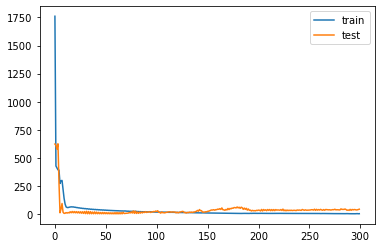

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

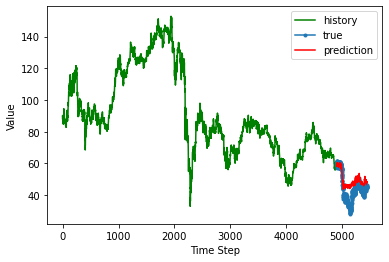

In [17]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [18]:
# plot_x=data[int(X.shape[0]*0.90):]
# plot_x["Prediction"]=y_test

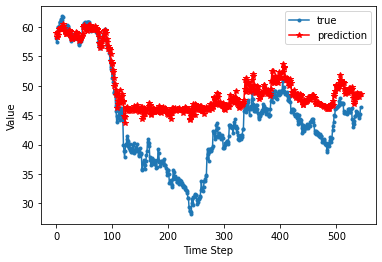

In [19]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [20]:
mean_absolute_percentage_error(y_test,y_pred)*100

13.72213557248865

In [21]:
mean_squared_error(y_test,y_pred)

42.96000605238293

In [22]:
r2_score(y_test,y_pred)

0.3666268678012411

In [23]:
y_pred_lstm_final = np.zeros((len(y_pred)-1,))
y_test_t_final = np.zeros((len(y_test)-1,))
for i in range(len(y_pred)-1):
    if y_pred[i+1] >= y_pred[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test)-1):
    if y_test[i+1] >= y_test[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
Predicted direction accuracy (Up/down):
0.5248618784530387


In [24]:
print(y_test_t_final)

[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.